# NIFTY50 Single stocks analysis
**Notebook contains analysis and forecast on a single stock.**


Importing necessary packages

In [1]:
!pip install livelossplot

In [2]:
from os import listdir
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from livelossplot import PlotLossesKeras
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
%autosave 30

Autosaving every 30 seconds


In [3]:
#dft = pd.read_csv(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\NIFTYMASTERDATA.csv',index_col='Date',parse_dates=True)

url = 'https://raw.githubusercontent.com/AsutoshDalei/stock-work/main/NIFTYMASTERDATA.csv'
dft = pd.read_csv(url,parse_dates=True)
dft['Date'] = pd.to_datetime(dft['Date'])
dft.set_index('Date',inplace = True)
dft

comps = dft.Symbol.unique()

In [4]:
dft

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12
...,...,...,...,...,...,...,...,...,...
2021-04-26,ZEEL,188.00,190.6,191.10,185.10,186.40,186.70,8542755,1.600451e+14
2021-04-27,ZEEL,186.40,188.0,192.95,186.80,188.15,188.80,14247767,2.698636e+14
2021-04-28,ZEEL,188.15,188.8,190.60,187.10,189.10,188.95,8429439,1.591917e+14


## Below are the companies the model will be monitoring

In [5]:
comps

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'MARUTI', 'MM', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [6]:
comp30 = ['INFY','TCS','RELIANCE','ICICIBANK','HDFC','HCLTECH','BHARTIARTL',
          'INDUSINDBK','SBIN','LT','TECHM','MM','AXISBANK','ITC','BAJAJ-AUTO','ONGC',
          'TATASTEEL','NTPC','TECHM','ASIANPAINT','POWERGRID','BAJAJFINSV','TITAN','NESTLEIND',
          'ULTRACEMCO','MARUTI','HDFCBANK','HINDUNILVR','SUNPHARMA','KOTAKBANK'  
         ]
len(comp30)

30

In [7]:
#comp30

## Various columns and the dataframe itself

In [8]:
cols = ['Symbol','Prev Close', 'Open', 'High', 'Low','Close' ,'Last','Volume', 'Turnover']
dft

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12
...,...,...,...,...,...,...,...,...,...
2021-04-26,ZEEL,188.00,190.6,191.10,185.10,186.40,186.70,8542755,1.600451e+14
2021-04-27,ZEEL,186.40,188.0,192.95,186.80,188.15,188.80,14247767,2.698636e+14
2021-04-28,ZEEL,188.15,188.8,190.60,187.10,189.10,188.95,8429439,1.591917e+14


## Get Data Function

In [9]:
def get_data(stock,feature):
    return dft[dft.Symbol == stock][feature]

## Generate Data Function
**This function returns a dataframe containing the following features of a stock:**
- Opening Price
- Day wise difference
- Consecutive day opening price difference
- MACD Histogram value for the day
- RSI value for the day

These features are returned as a dataframe, which will later be used for time series forecasting.

In [10]:
def generate_data(stock,feature,slow=26,fast=12,smooth=9,lookback=14):
    op = get_data(stock,'Open') # Open
    cl = get_data(stock,'Close') # Close
    vol = get_data(stock,'Volume') # Volume
    #diff = cl-op # Daily Difference
    ewa1 = op.ewm(span=slow,min_periods=0,adjust=False).mean()
    datf = ewa1.diff() # Consecutive Day Difference
    ewa2 = op.ewm(span=fast,min_periods=0,adjust=False).mean()
    macd = ewa2-ewa1
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    hist = macd - signal # MACD Difference
    
    #datf = op.diff()
    
    up = []
    down = []
    for i in range(len(datf)):
        if datf[i] < 0:
            up.append(0)
            down.append(datf[i])
        else:
            up.append(datf[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs)) # RSI
    
    final = {'open':op.values,'close':cl.values,'volume':vol,'cdiff':datf.values,
             'macdhist':hist.values,'rsi':rsi.values
            }
    
    df = pd.DataFrame(final)
    df.set_index(op.index,inplace=True)
    df.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    
    return df
    

In [11]:
%%time
df = generate_data('MARUTI','Open')
df

CPU times: user 84 ms, sys: 3.66 ms, total: 87.7 ms
Wall time: 93.7 ms


,open,close,volume,cdiff,macdhist,rsi
Date,,,,,,
2010-11-04,1501.00,1507.60,352793,1.777778,0.000000,100.000000
2010-11-05,1525.00,1512.35,40103,1.777778,1.531624,100.000000
2010-11-08,1515.00,1488.60,228488,0.905350,1.769658,100.000000
2010-11-09,1490.00,1471.95,382790,-1.013565,0.223119,95.652653
2010-11-10,1475.00,1475.10,209770,-2.049597,-1.723215,87.380120
...,...,...,...,...,...,...
2021-04-26,6690.20,6638.90,937344,-11.953606,0.907720,1.374358
2021-04-27,6669.95,6568.75,1610651,-12.568154,7.469229,1.309428
2021-04-28,6568.75,6573.80,1406270,-19.133476,6.024766,1.215296


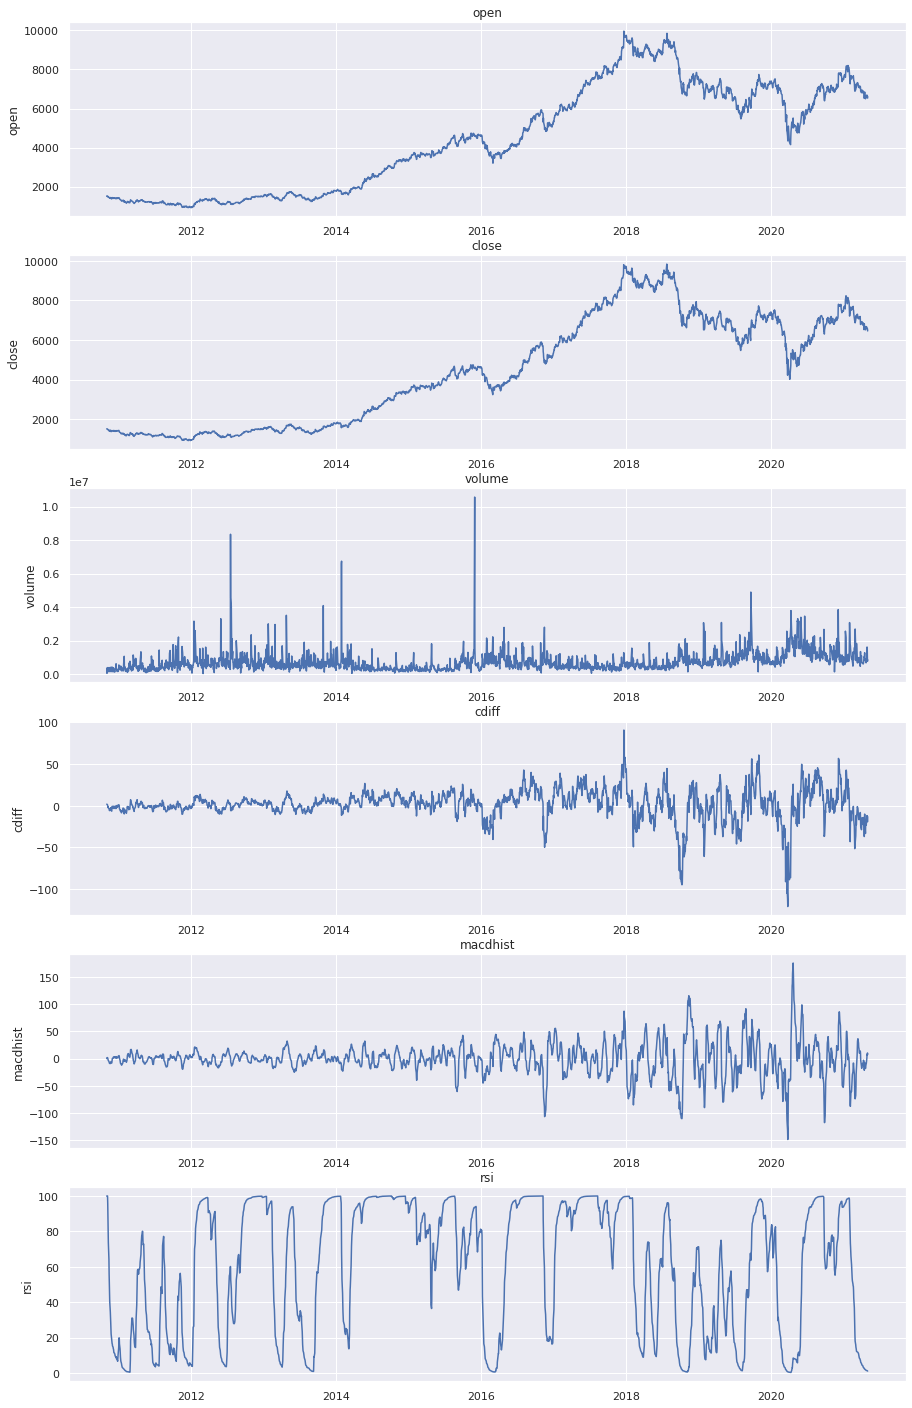

In [12]:
def plot_data(data):
    n = len(data.columns)
    plt.figure(figsize=(15,25))
    for i in range(n):
        plt.subplot(n,1,i+1)
        sns.lineplot(data = data,x = data.index, y = data.columns[i])
        plt.title(data.columns[i])
        plt.xlabel('')
        
plot_data(df)

In [13]:
df.shape

(2598, 6)

**For our task, the input data will be:** 
- Stock Opening Price
- Consecutive Day Difference
- MACD Histogram
- RSI

**While the target will be:**
- Daily Difference


In [14]:
ipfea = ['open','cdiff','macdhist','rsi','volume']
opfea = ['close']

**Since all our features are of a different scale, it is important for us to scale our data, for our model to run faster and not develop bias towards a higher scale feature** 

In [15]:
%%time
scaip = StandardScaler()
scaop = StandardScaler()
df[ipfea] = scaip.fit_transform(df[ipfea])
df[opfea] = scaop.fit_transform(df[opfea])
#df_sca = pd.DataFrame(sca.fit_transform(df),columns=df.columns)

CPU times: user 9.65 ms, sys: 0 ns, total: 9.65 ms
Wall time: 9.56 ms


In [16]:
def chunk(data,window=7):
    iparr,oparr = [],[]
    for i in tqdm(range(data.shape[0]-window)):
        iparr.append(data[ipfea].iloc[i:i+window])
        oparr.append(data[opfea].iloc[i+window])
    iparr,oparr = np.array(iparr),np.array(oparr)
    print(iparr.shape,oparr.shape)
    return iparr,oparr    
       

**We will keep data from start till 31/12/2020 for training and the data from 1/1/2021 for test**

In [17]:
%%time
date = '2021-01-01'
ips,ops = chunk(df.loc[:date])
ipt,opt = chunk(df.loc[date:])

100%|██████████| 2512/2512 [00:03<00:00, 749.66it/s]


(2512, 7, 5) (2512, 1)


100%|██████████| 73/73 [00:00<00:00, 845.93it/s]

(73, 7, 5) (73, 1)
CPU times: user 3.39 s, sys: 272 ms, total: 3.67 s
Wall time: 3.54 s


In [18]:
%%time
ipx,opx = shuffle(ips,ops,random_state=32)

CPU times: user 1.61 ms, sys: 0 ns, total: 1.61 ms
Wall time: 1.62 ms


In [19]:
df.head()

,open,close,volume,cdiff,macdhist,rsi
Date,,,,,,
2010-11-04,-1.090828,-1.089120,-0.609118,-0.014041,0.007080,1.069493
2010-11-05,-1.081909,-1.087351,-1.135564,-0.014041,0.058923,1.069493
2010-11-08,-1.085625,-1.096196,-0.818398,-0.062401,0.066981,1.069493
2010-11-09,-1.094915,-1.102397,-0.558615,-0.168768,0.014632,0.950447
2010-11-10,-1.100489,-1.101224,-0.849912,-0.226197,-0.051248,0.723916


## LSTM Model

In [20]:
import tensorflow as tf


In [21]:
{'act': 'tanh',
 'batch': 16,
 'drp': 0.017342822420160185,
 'lr': 0.0005363928590922107,
 'epoch': 45}

{'act': 'tanh',
 'batch': 16,
 'drp': 0.017342822420160185,
 'lr': 0.0005363928590922107,
 'epoch': 45}

In [22]:
act = 'tanh'
drp = 0.017342822420160185
model = tf.keras.models.Sequential([
                           tf.keras.layers.GRU(units=8,activation=act,return_sequences=True,
                                                input_shape=(ipx.shape[1],ipx.shape[2])),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
    
                           #tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           #tf.keras.layers.Dropout(drp),
                           #tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           #tf.keras.layers.Dropout(drp),
    
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=8,activation='tanh',return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=4,activation=act),
                           tf.keras.layers.Dense(units=1)
                          ])

2022-05-16 15:39:47.583330: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [23]:
%%time
tf.keras.backend.clear_session()

opti = tf.optimizers.Adam(learning_rate=0.0005363928590922107)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',min_lr=0.0001,factor = 0.05)
early_stp = tf.keras.callbacks.EarlyStopping('loss',patience=25)


model.compile(optimizer=opti,loss='mean_absolute_error')
#history=model.fit(ipx,opx,epochs=150,batch_size=16,verbose=0,callbacks=[PlotLossesKeras(),early_stp])

CPU times: user 12.7 ms, sys: 0 ns, total: 12.7 ms
Wall time: 12.7 ms


In [24]:
#model.summary()

In [25]:
opp = model.predict(ipt)

2022-05-16 15:39:49.771303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [26]:
lossfn = tf.keras.losses.MeanSquaredError()
lossfn(opt,opp).numpy()

1.0546423

1.0546423


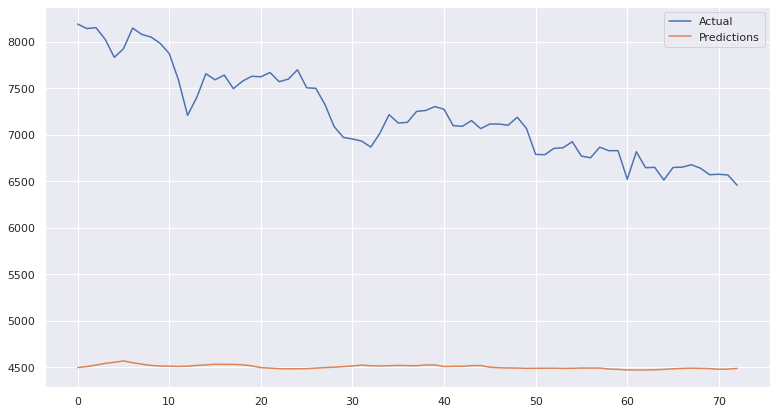

In [27]:
def plot_res(model=model,ipx=ipt,opx=opt,scaled = True):
    opp = model.predict(ipx)
    lossfn = tf.keras.losses.MeanSquaredError()
    print(lossfn(opx,model.predict(ipx)).numpy())
    
    plt.figure(figsize=(13,7))
    if scaled:
        plt.plot(opx,label = 'Actual')
        plt.plot(opp, label = 'Predictions')
    else:
        opt1 = scaop.inverse_transform(opx)
        opp1 = scaop.inverse_transform(opp)
        plt.plot(opt1,label = 'Actual')
        plt.plot(opp1, label = 'Predictions')
        
        
    plt.legend()
    return

plot_res(ipx=ipt,opx=opt,scaled = False)

## Transfer Learning Attempt

In [28]:
def flow_fn(stock,model=model,feature = 'Open',scaled = False):
    dfl = generate_data(stock,'Open')
    
    
    scaipl = StandardScaler()
    scaopl = StandardScaler()
    dfl[ipfea] = scaipl.fit_transform(dfl[ipfea])
    dfl[opfea] = scaopl.fit_transform(dfl[opfea])
    #return dfl
    ipl,opl = chunk(dfl)
    
    plot_res(model = model,ipx = ipl,opx = opl,scaled = scaled)
    return

MARUTI


100%|██████████| 2591/2591 [00:03<00:00, 822.61it/s]


(2591, 7, 5) (2591, 1)
0.9550951
CPU times: user 6.62 s, sys: 1.19 s, total: 7.81 s
Wall time: 5.94 s


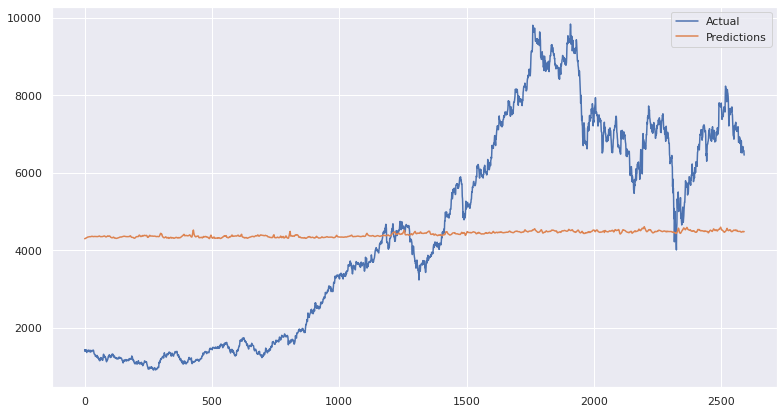

In [29]:
%%time
stk = comp30[9]
stk = np.random.choice(comp30)
stk = 'MARUTI'
print(stk)
flow_fn(stock = stk)

**As we see, the model's predictions on different stocks are not greatly bad. There is scope of improvement which can be implement towards building a generalized model.**

## Optuna Hyper Parameter tuning

In [30]:
#!pip install optuna
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.layers import GRU,Dense

In [31]:
def savebest(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

def objective(trial):
    act = trial.suggest_categorical("act", ["tanh", "relu"])
    batch = trial.suggest_categorical("batch", [8,16,32,64,128])
    drp = trial.suggest_uniform('drp', 0.0, 0.7)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    epoch = trial.suggest_int("epoch", 30,55)
    
    layers = trial.suggest_int('layers',5,10)
    units = trial.suggest_int('units',64,256)

    
    
    monitor = "loss"
    callbacks = [TFKerasPruningCallback(trial, monitor)]
    #early_stop = EarlyStopping(monitor='val_loss',patience=3,min_delta = 0.0001)
    opti = tf.keras.optimizers.Adam(learning_rate=lr)
    
    global model
    
    model = tf.keras.models.Sequential()
    model.add(GRU(units=8,activation='tanh',return_sequences=True,input_shape=(ipx.shape[1],ipx.shape[2])))
    model.add(GRU(units=16,activation = act,return_sequences=True))
    model.add(tf.keras.layers.Dropout(drp))
    
    for lay in range(layers):
        model.add(GRU(units = units,activation=act,return_sequences=True))
        model.add(tf.keras.layers.Dropout(drp))
    
    model.add(GRU(units=16,activation = act,return_sequences=True))
    model.add(GRU(units=8,activation = act))
    model.add(Dense(units=1))

    tf.keras.backend.clear_session()
    model.compile(optimizer=opti,loss='mean_absolute_error')

    model.fit(ipx,opx, epochs = epoch, batch_size = batch,verbose = 0,
                     callbacks=callbacks)
    
    
    return model.evaluate(ipt,opt)

In [32]:
%%time
study = optuna.create_study(direction='minimize', 
            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials = 50,callbacks=[savebest])

[I 2022-05-16 15:40:02,780] A new study created in memory with name: no-name-8783318e-b962-4322-93bd-75a6894a3a99


3/3 [==============================] - 3s 51ms/step - loss: 0.2311


[I 2022-05-16 15:45:09,816] Trial 0 finished with value: 0.2310533970594406 and parameters: {'act': 'relu', 'batch': 64, 'drp': 0.2692663161273061, 'lr': 0.0007476932101597925, 'epoch': 46, 'layers': 7, 'units': 203}. Best is trial 0 with value: 0.2310533970594406.


3/3 [==============================] - 4s 60ms/step - loss: 0.1589


[I 2022-05-16 15:55:19,887] Trial 1 finished with value: 0.15886089205741882 and parameters: {'act': 'tanh', 'batch': 16, 'drp': 0.5388511299495055, 'lr': 2.3547616828563555e-05, 'epoch': 49, 'layers': 7, 'units': 168}. Best is trial 1 with value: 0.15886089205741882.
[I 2022-05-16 15:55:49,882] Trial 2 pruned. Trial was pruned at epoch 1.


3/3 [==============================] - 2s 29ms/step - loss: 0.1588


[I 2022-05-16 15:57:07,077] Trial 3 finished with value: 0.1588219851255417 and parameters: {'act': 'relu', 'batch': 128, 'drp': 0.471895313014674, 'lr': 0.002838166505824001, 'epoch': 36, 'layers': 5, 'units': 64}. Best is trial 3 with value: 0.1588219851255417.
[I 2022-05-16 15:57:53,509] Trial 4 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 15:58:31,847] Trial 5 pruned. Trial was pruned at epoch 3.


3/3 [==============================] - 5s 196ms/step - loss: 0.1107


[I 2022-05-16 16:03:50,933] Trial 6 finished with value: 0.11065637320280075 and parameters: {'act': 'tanh', 'batch': 128, 'drp': 0.31212135785817685, 'lr': 0.00038891592168491945, 'epoch': 41, 'layers': 8, 'units': 245}. Best is trial 6 with value: 0.11065637320280075.
[I 2022-05-16 16:04:42,023] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2022-05-16 16:05:22,963] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2022-05-16 16:06:06,757] Trial 9 pruned. Trial was pruned at epoch 1.
[I 2022-05-16 16:07:19,092] Trial 10 pruned. Trial was pruned at epoch 3.


3/3 [==============================] - 6s 66ms/step - loss: 0.1026


[I 2022-05-16 16:25:32,931] Trial 11 finished with value: 0.10257270932197571 and parameters: {'act': 'tanh', 'batch': 8, 'drp': 0.11826351163784186, 'lr': 0.00015379479242286898, 'epoch': 37, 'layers': 10, 'units': 128}. Best is trial 11 with value: 0.10257270932197571.


3/3 [==============================] - 2s 53ms/step - loss: 0.3157


[I 2022-05-16 16:38:39,857] Trial 12 finished with value: 0.3156932294368744 and parameters: {'act': 'relu', 'batch': 16, 'drp': 0.47494202572696426, 'lr': 0.0018870345574900798, 'epoch': 50, 'layers': 6, 'units': 235}. Best is trial 11 with value: 0.10257270932197571.
[I 2022-05-16 16:39:44,838] Trial 13 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 16:41:15,242] Trial 14 pruned. Trial was pruned at epoch 1.


3/3 [==============================] - 4s 31ms/step - loss: 0.0684


[I 2022-05-16 16:50:18,676] Trial 15 finished with value: 0.06837018579244614 and parameters: {'act': 'tanh', 'batch': 8, 'drp': 0.01269550410766035, 'lr': 0.0001105591595406431, 'epoch': 36, 'layers': 5, 'units': 70}. Best is trial 15 with value: 0.06837018579244614.


3/3 [==============================] - 3s 68ms/step - loss: 0.0603


[I 2022-05-16 17:06:28,529] Trial 16 finished with value: 0.06029175966978073 and parameters: {'act': 'relu', 'batch': 16, 'drp': 0.08174489761354757, 'lr': 0.0002970664105867037, 'epoch': 53, 'layers': 10, 'units': 182}. Best is trial 16 with value: 0.06029175966978073.
[I 2022-05-16 17:08:59,717] Trial 17 pruned. Trial was pruned at epoch 9.
[I 2022-05-16 17:09:43,168] Trial 18 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 17:16:25,538] Trial 19 pruned. Trial was pruned at epoch 27.


3/3 [==============================] - 3s 57ms/step - loss: 0.1529


[I 2022-05-16 17:24:09,032] Trial 20 finished with value: 0.15292717516422272 and parameters: {'act': 'relu', 'batch': 32, 'drp': 0.18720352521456005, 'lr': 4.868188118759008e-05, 'epoch': 36, 'layers': 7, 'units': 217}. Best is trial 16 with value: 0.06029175966978073.
[I 2022-05-16 17:25:34,835] Trial 21 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 17:26:42,794] Trial 22 pruned. Trial was pruned at epoch 1.
[I 2022-05-16 17:28:23,405] Trial 23 pruned. Trial was pruned at epoch 9.
[I 2022-05-16 17:36:33,860] Trial 24 pruned. Trial was pruned at epoch 27.


3/3 [==============================] - 6s 47ms/step - loss: 0.0780


[I 2022-05-16 17:48:07,640] Trial 25 finished with value: 0.07796576619148254 and parameters: {'act': 'tanh', 'batch': 16, 'drp': 0.28735994080743865, 'lr': 0.0001666087082205797, 'epoch': 46, 'layers': 10, 'units': 121}. Best is trial 16 with value: 0.06029175966978073.
[I 2022-05-16 17:48:58,321] Trial 26 pruned. Trial was pruned at epoch 1.
[I 2022-05-16 17:49:45,634] Trial 27 pruned. Trial was pruned at epoch 1.


3/3 [==============================] - 2s 42ms/step - loss: 0.5187


[I 2022-05-16 18:02:52,576] Trial 28 finished with value: 0.5187405943870544 and parameters: {'act': 'relu', 'batch': 8, 'drp': 0.5627181225538813, 'lr': 0.0001237524089260334, 'epoch': 40, 'layers': 5, 'units': 182}. Best is trial 16 with value: 0.06029175966978073.


3/3 [==============================] - 3s 82ms/step - loss: 0.2795


[I 2022-05-16 18:16:59,017] Trial 29 finished with value: 0.2795241177082062 and parameters: {'act': 'relu', 'batch': 16, 'drp': 0.42914115769973865, 'lr': 0.0003775763815490538, 'epoch': 37, 'layers': 10, 'units': 242}. Best is trial 16 with value: 0.06029175966978073.
[I 2022-05-16 18:20:22,204] Trial 30 pruned. Trial was pruned at epoch 27.
[I 2022-05-16 18:21:32,158] Trial 31 pruned. Trial was pruned at epoch 1.


3/3 [==============================] - 3s 45ms/step - loss: 0.1117


[I 2022-05-16 18:38:43,969] Trial 32 finished with value: 0.11167782545089722 and parameters: {'act': 'relu', 'batch': 8, 'drp': 0.13151514149560223, 'lr': 0.0007182198729938805, 'epoch': 35, 'layers': 10, 'units': 94}. Best is trial 16 with value: 0.06029175966978073.


3/3 [==============================] - 4s 32ms/step - loss: 0.0523


[I 2022-05-16 18:46:50,152] Trial 33 finished with value: 0.052251655608415604 and parameters: {'act': 'tanh', 'batch': 8, 'drp': 0.05307541784615262, 'lr': 0.0007484051291448835, 'epoch': 33, 'layers': 5, 'units': 68}. Best is trial 33 with value: 0.052251655608415604.
[I 2022-05-16 18:47:52,105] Trial 34 pruned. Trial was pruned at epoch 9.


3/3 [==============================] - 4s 29ms/step - loss: 0.0899


[I 2022-05-16 18:55:40,812] Trial 35 finished with value: 0.08993438631296158 and parameters: {'act': 'tanh', 'batch': 8, 'drp': 0.03921146255943279, 'lr': 0.0022992928852465927, 'epoch': 33, 'layers': 5, 'units': 68}. Best is trial 33 with value: 0.052251655608415604.
[I 2022-05-16 18:58:05,334] Trial 36 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 18:59:27,372] Trial 37 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 19:01:41,962] Trial 38 pruned. Trial was pruned at epoch 9.
[I 2022-05-16 19:07:40,378] Trial 39 pruned. Trial was pruned at epoch 9.
[I 2022-05-16 19:08:40,499] Trial 40 pruned. Trial was pruned at epoch 9.
[I 2022-05-16 19:10:59,203] Trial 41 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 19:12:31,552] Trial 42 pruned. Trial was pruned at epoch 3.
[I 2022-05-16 19:26:41,133] Trial 43 pruned. Trial was pruned at epoch 27.
[I 2022-05-16 19:27:40,058] Trial 44 pruned. Trial was pruned at epoch 3.


3/3 [==============================] - 2s 34ms/step - loss: 1.2159


[I 2022-05-16 19:31:48,627] Trial 45 finished with value: 1.2158501148223877 and parameters: {'act': 'relu', 'batch': 64, 'drp': 0.5762709100572203, 'lr': 0.007600113547768567, 'epoch': 48, 'layers': 5, 'units': 187}. Best is trial 33 with value: 0.052251655608415604.


3/3 [==============================] - 3s 158ms/step - loss: 0.0747


[I 2022-05-16 19:39:23,563] Trial 46 finished with value: 0.07467851787805557 and parameters: {'act': 'relu', 'batch': 32, 'drp': 0.01255935771944501, 'lr': 0.0007747831933099864, 'epoch': 55, 'layers': 7, 'units': 126}. Best is trial 33 with value: 0.052251655608415604.
[I 2022-05-16 19:40:14,149] Trial 47 pruned. Trial was pruned at epoch 3.


3/3 [==============================] - 3s 33ms/step - loss: 0.0620


[I 2022-05-16 19:48:07,725] Trial 48 finished with value: 0.06204172596335411 and parameters: {'act': 'tanh', 'batch': 8, 'drp': 0.00580488170957301, 'lr': 0.0009384999870003646, 'epoch': 32, 'layers': 5, 'units': 86}. Best is trial 33 with value: 0.052251655608415604.
[I 2022-05-16 19:48:56,312] Trial 49 pruned. Trial was pruned at epoch 1.


CPU times: user 6h 9min 15s, sys: 1h 22min 8s, total: 7h 31min 23s
Wall time: 4h 8min 53s


def savebest(study, trial):
    global best_model
    if study.best_trial == trial:
        best_model = model

def objective(trial):
    act = trial.suggest_categorical("act", ["tanh", "relu"])
    batch = trial.suggest_categorical("batch", [16,32,64,128])
    drp = trial.suggest_uniform('drp', 0.0, 0.7)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    epoch = trial.suggest_int("epoch", 30,55)
    

    
    
    monitor = "loss"
    callbacks = [TFKerasPruningCallback(trial, monitor)]
    #early_stop = EarlyStopping(monitor='val_loss',patience=3,min_delta = 0.0001)
    opti = tf.keras.optimizers.Adam(learning_rate=lr)
    
    global model
    drp = 0.2
    model = tf.keras.models.Sequential([
                           tf.keras.layers.GRU(units=8,activation=act,return_sequences=True,
                                                input_shape=(ipx.shape[1],ipx.shape[2])),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
    
                           tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=128,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
    
                           tf.keras.layers.GRU(units=64,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=16,activation=act,return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=8,activation='tanh',return_sequences=True),
                           tf.keras.layers.Dropout(drp),
                           tf.keras.layers.GRU(units=4,activation=act),
                           tf.keras.layers.Dense(units=1)
                          ])
    
    tf.keras.backend.clear_session()
    model.compile(optimizer=opti,loss='mean_absolute_error')

    model.fit(ipx,opx, epochs = epoch, batch_size = batch,verbose = 0,
                     callbacks=callbacks)
    
    
    return model.evaluate(ipt,opt)

%%time
study = optuna.create_study(direction='minimize', 
            pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective,n_trials = 70,callbacks=[savebest])

In [33]:
best_params = study.best_params
best_params

{'act': 'tanh',
 'batch': 8,
 'drp': 0.05307541784615262,
 'lr': 0.0007484051291448835,
 'epoch': 33,
 'layers': 5,
 'units': 68}

In [34]:
optuna.visualization.plot_optimization_history(study)

In [35]:
optuna.visualization.plot_intermediate_values(study)

In [36]:
optuna.visualization.plot_slice(study)

In [37]:
optuna.visualization.plot_parallel_coordinate(study)

0.0045591965


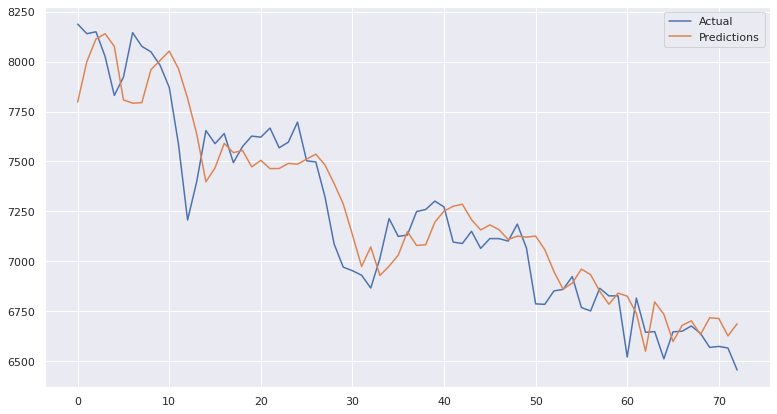

In [38]:
plot_res(model = best_model,ipx=ipt,opx=opt,scaled = False)

ONGC


100%|██████████| 2591/2591 [00:03<00:00, 745.88it/s]


(2591, 7, 5) (2591, 1)
0.30060408
CPU times: user 8.78 s, sys: 1.71 s, total: 10.5 s
Wall time: 7.68 s


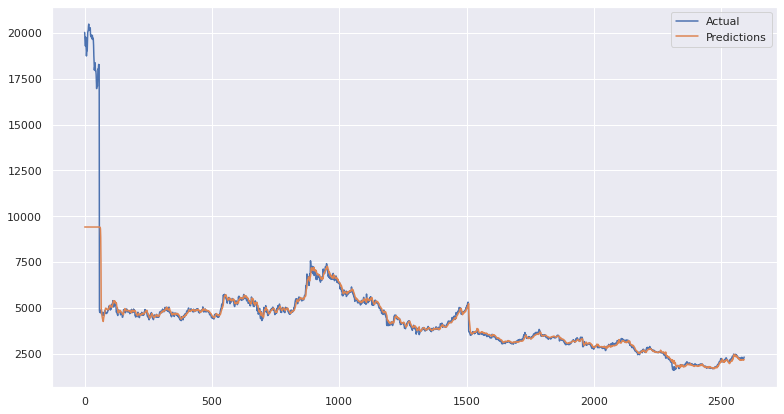

In [39]:
%%time
stk = comp30[9]
#stk = 'MARUTI'
stk = np.random.choice(comp30)
print(stk)
flow_fn(stock = stk,model = best_model)

In [40]:
def prepdata(features,ime,data, jump = 1,lookup =  14,targets=2):
    ipdat,opdat = [],[]
    data = data[data.imei == ime]
    if targets == 3:
        data = pd.get_dummies(data,columns=['zone'])
        #data = data.replace(['good','warning','critical'],[0,1,2])
    else:
        data = data.replace(['good','warning','critical'],[0,0,1])
        
    for i in range(0,len(data)-lookup, jump):
        if len(features) == 1:
            res = data[i:i+lookup][features[0]].values
        else:
            res = data[i:i+lookup][features].values
        
        #CHANGE HERE FOR 2D-3D FORM OF I/P DATA
        #ipdat.append(np.ravel(res))
        ipdat.append(res)
        
        if targets == 3:
            y = data[['zone_good','zone_warning','zone_critical']].iloc[i+lookup-1].values
        else:
            y = data['zone'].iloc[i+lookup-1]
        #print(y)
        opdat.append(y) 
    
    ipdat = np.array(ipdat)
    opdat = np.array(opdat)
    #print(ipdat.shape, opdat.shape)
    return ipdat,opdat


def pushdata(features,arr, lookup = 14,scale = False,targets=2):
    flag = True
    jump = 1
    for i in tqdm(arr):
        if datafull[datafull.imei == i].shape[0] < 100:
            continue
        if flag:
            ipt,opt = prepdata(features,ime = i, jump = jump, lookup = lookup,targets = targets)
            flag = False
            continue 
        a,b = prepdata(features,ime = i,  jump = jump, lookup = lookup,targets = targets)
        ipt = np.concatenate((ipt,a))
        opt = np.concatenate((opt,b))
    print(ipt.shape,opt.shape)
    return ipt,opt

